In [1]:
import pandas as pd
import csv
import numpy as np
import sys
from collections import Counter, OrderedDict
import math
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from statistics import mean
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from ast import literal_eval


In [7]:
data = pd.read_csv('./training-data.tsv')
data

,pop\thold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little turn dust play house ruin run leave save like chase train late late tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little run leave save like chase train know late late play break string feel heart want feel tell real truth hurt lie worse anymore little know little hold time feel
0,pop\tbelieve drop rain fall grow believe darke...
1,pop\tsweetheart send letter goodbye secret fee...
2,pop\tkiss lips want stroll charm mambo chacha ...
3,pop\ttill darling till matter know till dream ...
4,pop\tconvoy light dead ahead merchantmen trump...
...,...
28338,hip hop\tfabolous hahahaha yeah ghetto superst...
28339,hip hop\theroes tryna glock straight work nigg...
28340,hip hop\tsit eazy believe alright eazy tell li...
28341,hip hop\tknow right clear streets come track n...


stuff added by bing below

In [15]:
csvfile = open('tcc_ceds_music.csv', newline='', encoding='utf-8')
reader = csv.reader(csvfile, delimiter=',')
i = 0
for row in reader:
  genre = row[4]
  lyrics = row[5]
  # print(genre, lyrics)
  i += 1
  # if i == 5:
  #   break
print(i)

28373


In [16]:
def generate_tuples_from_file(training_file_path):
    """
    Generates tuples from file formated like:
    id\ttext\tlabel
    Parameters:
    training_file_path - str path to file to read in
    Return:
    a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
    """
    f = open(training_file_path, "r", encoding="utf8")
    listOfExamples = []
    for review in f:
        if len(review.strip()) == 0:
            continue
        dataInReview = review.split("\t")
        for i in range(len(dataInReview)):
      # remove any extraneous whitespace
            dataInReview[i] = dataInReview[i].strip()
        t = tuple(dataInReview)
        listOfExamples.append(t)
    f.close()
    return listOfExamples

In [27]:
def generate_tuples_from_file(training_file_path):
    """
    Generates tuples from file formated like:
    id\ttext\tlabel
    Parameters:
        training_file_path - str path to file to read in
    Return:
        a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
    """
    f = open(training_file_path, "r", encoding="utf8")
    listOfExamples = []
    for review in f:
        if len(review.strip()) == 0:
            continue
        dataInReview = review.split("\t")
        for i in range(len(dataInReview)):
            # remove any extraneous whitespace
            dataInReview[i] = dataInReview[i].strip()
        t = tuple(dataInReview)
        listOfExamples.append(t)
    f.close()
    return listOfExamples

def precision(gold_labels, predicted_labels):
    """
    Calculates the precision for a set of predicted labels give the gold (ground truth) labels.
    Parameters:
        gold_labels (list): a list of labels assigned by hand ("truth")
        predicted_labels (list): a corresponding list of labels predicted by the system
    Returns: double precision (a number from 0 to 1)
    """
    den = 0
    num = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == '1':
            den += 1
            if gold_labels[i] == '1':
                num += 1
    if den == 0:
        return 0.0
    else:
        return float(num / den)

def recall(gold_labels, predicted_labels):
    """
    Calculates the recall for a set of predicted labels give the gold (ground truth) labels.
    Parameters:
            gold_labels (list): a list of labels assigned by hand ("truth")
            predicted_labels (list): a corresponding list of labels predicted by the system
    Returns: double recall (a number from 0 to 1)
    """
    den = 0
    num = 0
    for i in range(len(gold_labels)):
        if gold_labels[i] == '1':
            den += 1
            if predicted_labels[i] == '1':
                num += 1
    if den == 0:
        return 0.0
    else:
        return float(num / den)

def f1(gold_labels, predicted_labels):
    """
    Calculates the f1 for a set of predicted labels give the gold (ground truth) labels.
    Parameters:
            gold_labels (list): a list of labels assigned by hand ("truth")
            predicted_labels (list): a corresponding list of labels predicted by the system
    Returns: double f1 (a number from 0 to 1)
    """
    precision_score = precision(gold_labels, predicted_labels)
    recall_score = recall(gold_labels, predicted_labels)
    num = 2 * precision_score * recall_score
    den = precision_score + recall_score
 
    if den == 0:
        return 0.0
    else:
        return float(num / den)


def precision_multiclass_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_precisions = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(classified_labels)):
            if classified_labels[i] == _class:
                den += 1
                if gold_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_precisions[_class] = float(num / den)
    return class_precisions


def precision_multiclass(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multiclass_dict(gold_labels, classified_labels)
    return float(mean(precision_dict.values()))
    

def recall_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_recalls = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(gold_labels)):
            if gold_labels[i] == _class:
                den += 1
                if classified_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_recalls[_class] = float(num / den)
    return class_recalls



def recall_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    recall_dict = recall_multi_dict(gold_labels, classified_labels)
    return float(mean(recall_dict.values()))


def f1_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multiclass_dict(gold_labels, classified_labels)
    recall_dict = recall_multi_dict(gold_labels, classified_labels)

    classes = precision_dict.keys()

    f1_scores = []
    for _class in classes:
        class_precision = precision_dict[_class]
        class_recall = recall_dict[_class]
        if class_precision + class_recall == 0:
            f1_scores.append(0.0)
        else:
            f1_scores.append(float((2 * class_precision * class_recall) / (class_precision + class_recall)))

    return mean(f1_scores)


"""
Implement any other non-required functions here
"""

def preprocess_text(data):
    '''
    First, performs text normalization using the SnowballStemmer to perform stemming of all words in sentence after 
    tokenization is done (1).
    Removes all stop words from the sentence, except for 'not' (2).
    Pre-processes text by adding negation to all words that come after the not_words, before a punctuation, another not word,
    or end of sentence (3).
    Finally, removes punctuation from sentence tokens (3).  
    Parameters:
        data (str): sentence string 
    Returns: list - sentence tokens after preprocessing 

    '''
    # tokenization
    tokens = word_tokenize(data)

    # token stemming
    # sb = SnowballStemmer('english')
    # tokens = [sb.stem(w) for w in tokens]

    # Removing stopwords from token (other than not)
    _stopwords = stopwords.words("english")
    _stopwords.remove('not')
    tokens = [w for w in tokens if w.lower() not in _stopwords]

    # Negates all words after a not_word in the sentence tokens
    not_words = ['n\'t', 'not', 'no', 'never']
    tokens_len = len(tokens)
    for i in range(tokens_len):
        if tokens[i] in not_words:
            j = i + 1
            while (j < tokens_len and tokens[j] not in not_words and tokens[j].isalpha()):
                tokens[j] = 'NOT_{}'.format(tokens[j])
                j += 1
            i = j

    # Removes punctuation 
    punctuations = '''!()-[];:'"\,<>./?@#$%^&*_~'''
    tokens = [w for w in tokens if w not in punctuations]

    return tokens

def k_fold(all_examples, k):
    # all_examples is a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
    # containing all examples from the train and dev sets
    # return a list of lists containing k sublists where each sublist is one "fold" in the given data

    examples_split = np.array_split(all_examples, k)
    # examples_split = [all_examples[i:i+k] for i in range(0, len(all_examples), k)]
    return examples_split

def perform_kfold(model, all_examples, k):
    '''
    Performs k-fold validation on a combined data set with the training and dev set. The model is trained and evaluated
    by training on k-1 folds and testing on the last fold. The precision, recall, and f1 score of each fold is printed 
    Parameter:
        model (TextClassify or TextClassifyImproved): model to use in k-fold experiments 
        all_examples (list of lists): combined training and dev sets 
        k (int): k paramater used for k-fold experiment 
    Returns: None
    '''
    examples_split = k_fold(all_examples, k)
    precisions = []
    recalls = []
    f1s = []
    for i in range(k):
        model.reset()
        exp = copy.deepcopy(examples_split)

        # Selects one of the k folds for the dev set
        dev = exp.pop(i)
        training = [item for sublist in exp for item in sublist]

        model.train(training)

        predicted_labels = []
        gold_labels = []
        for dev_review in dev:
            gold_labels.append(dev_review[2])
            prediction = model.classify(dev_review[1])
            predicted_labels.append(prediction)

        # Gets the precision, recall, and f1 for each of the k folds 
        precision_score = precision(gold_labels, predicted_labels)
        recall_score = recall(gold_labels, predicted_labels)
        f1_score = f1(gold_labels, predicted_labels)

        precisions.append(precision_score)
        recalls.append(recall_score)
        f1s.append(f1_score)

        print('K fold #{}'.format(i + 1))
        print('Precision score : {}'.format(precision_score))
        print('Recall score : {}'.format(recall_score))
        print('F1 score : {}'.format(f1_score))
        print('\n')

    print("Average precision score: {}".format(mean(precisions)))
    print("Average recall score: {}".format(mean(recalls)))
    print("Average f1 score: {}".format(mean(f1s)))


"""
implement your TextClassify class here
"""
class TextClassify:


    def __init__(self):
        self.reset()

    def reset(self):
        '''
        Essentially initializes a new model by resetting all training data
        '''
        self.vocab_set = set()
        self.class_words_lists = Counter()
        self.total_docs = 0
        self.class_count = Counter()

    def process_data(self, data):
        '''
        Processes the data - in the basic model, all that is needed is splitting the text
        Parameters:
            data (str): data to process
        Returns list - text split into seperate words 
        '''
        return data.split()

    def process_example(self, example):
        '''
        Processes the example string - in the basic model, all that is needed is splitting the text
        Parameters:
            example (str): example to process
        Returns list - text split into seperate words 
        '''
        return example.split()

    def train(self, examples):
        """
        Trains the classifier based on the given examples
        Parameters:
            examples - a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
        Return: None
        """
        for review in examples:
            self.total_docs += 1

            label = review[0]
            if label not in self.class_count:
                self.class_count[label] = 1
            else:
                self.class_count[label] += 1

            text = self.process_example(review[1])
            self.vocab_set.update(set(text))
            if label not in self.class_words_lists:
                self.class_words_lists[label] = text
            else:
                self.class_words_lists[label].extend(text)


    def score(self, data):
        """
        Score a given piece of text
        Parameters:
            data - str like "I loved the hotel"
        Return: dict of class: score mappings
        """
        classes = self.class_count.keys()
        class_scores = Counter()

        text = self.process_data(data)

        for label in classes:
            prior = np.log(self.class_count[label] / self.total_docs)

            log_sum = 0
            for word in text:
                if word in self.vocab_set:
                    word_class_count = self.class_words_lists[label].count(word) + 1
                    class_total_word_count = len(self.class_words_lists[label]) + len(self.vocab_set)
                    log_likelihood = np.log(word_class_count / class_total_word_count)
                    log_sum += log_likelihood
            score = np.exp(prior + log_sum)
            class_scores[label] = score

        return class_scores


    def classify(self, data):
        """
        Label a given piece of text
        Parameters:
            data - str like "I loved the hotel"
        Return: string class label
        """
        class_scores = self.score(data)
        class_scores_sorted = OrderedDict(sorted(class_scores.items()))
        return max(class_scores_sorted, key=class_scores_sorted.get)

    def featurize(self, data):
        """
        we use this format to make implementation of your TextClassifyImproved model more straightforward and to be 
        consistent with what you see in nltk
        Parameters:
            data - str like "I loved the hotel"
        Return: a list of tuples linking features to values
        for BoW, a list of tuples linking every word to True [("I", True), ("loved", True), ("it", True)]
        """
        output = []
        for word in self.process_data(data):
            output.append((word, True))
        return output

    def __str__(self):
        return "Naive Bayes - bag-of-words baseline"


class TextClassifyImproved(TextClassify):
    '''
    Subclass of TextClassify with preprocessing of text enabled. 
    '''

    def process_examples(self, examples):
        '''
        Preprocess the text sentences in the examples
        Parameters:
            examples: list - list of examples to preprocess text
        Returns: list - examples with the text preprocessed to use in the improved model
        '''
        processed_reviews = []
        for review in examples:
            review_id, text, score = review
            text = preprocess_text(text)
            processed_reviews.append((review_id, text, score))
        return processed_reviews

    def process_data(self, data):
        '''
        Processes the data - in the improved model, the data is preprocessed
        Parameters:
            data (str): data to process
        Returns list - text split into seperate words and preprocessed  
        '''
        return preprocess_text(data)

    def process_example(self, example):
        '''
        Processes the example string - in the improved model, the string is left alone since it is already preprocessed 
        Parameters:
            example (list): example to process
        Returns list - example is left alone 
        '''
        return example

    def train(self, examples):
        """
        Trains the classifier based on the given examples. First, the examples are preprocessed, and the model is trained with these
        processed examples. 
        Parameters:
            examples - a list of tuples of strings formatted [(id, [example_tokens], label), (id, [example_tokens], label)....]
        Return: None
        """
        examples = self.process_examples(examples)
        TextClassify.train(self, examples)

    def __str__(self):
        return "Improved Naive Bayes with text pre-processing"


def main():

    training = sys.argv[1]
    testing = sys.argv[2]

    examples = generate_tuples_from_file(training)
    testExamples = generate_tuples_from_file(testing)

    # TextClassify BASIC model 
    classifier = TextClassify()
    print(classifier)
    # do the things that you need to with your base class
    classifier.train(examples)

    # report precision, recall, f1
    predicted_labels = []
    gold_labels = []
    for testReview in testExamples:
        gold_labels.append(testReview[2])
        prediction = classifier.classify(testReview[1])
        predicted_labels.append(prediction)

    print('Precision score : {}'.format(precision(gold_labels, predicted_labels)))
    print('Recall score : {}'.format(recall(gold_labels, predicted_labels)))
    print('F1 score : {}'.format(f1(gold_labels, predicted_labels)))
    print('\n')

    # TextClassify IMPROVED model 
    improved = TextClassifyImproved()
    print(improved)
    # do the things that you need to with your improved class
    improved.train(examples)

    # report final precision, recall, f1 (for your best model)
    predicted_labels = []
    gold_labels = []
    for testReview in testExamples:
        gold_labels.append(testReview[2])
        prediction = improved.classify(testReview[1])
        predicted_labels.append(prediction)

    print('Precision score : {}'.format(precision(gold_labels, predicted_labels)))
    print('Recall score : {}'.format(recall(gold_labels, predicted_labels)))
    print('F1 score : {}'.format(f1(gold_labels, predicted_labels)))
    print('\n')

    # K Fold
    all_examples = examples + testExamples
    # Using improved model in k-fold experiments
    tci = TextClassifyImproved()
    print(tci)
    print('K fold experiment \n')
    perform_kfold(tci, all_examples, 10)


    # MULTICLASS EXPERIMENTATION
    multiclass_examples = generate_tuples_from_file('multiclass_train.txt')
    multiclass_test = generate_tuples_from_file('multiclass_test.txt')
    # TextClassify IMPROVED model 
    improved_multiclass = TextClassifyImproved()
    print('\n')
    print(improved_multiclass)
    print('MULTICLASS EXPERIMENTATION')

    improved_multiclass.train(multiclass_examples)

    # report final precision, recall, f1 (for your multiclass model)
    predicted_labels = []
    gold_labels = []
    for example in multiclass_test:
        gold_labels.append(example[2])
        prediction = improved_multiclass.classify(example[1])
        predicted_labels.append(prediction)

    print('Precision score : {}'.format(precision_multiclass(gold_labels, predicted_labels)))
    print('Recall score : {}'.format(recall_multi(gold_labels, predicted_labels)))
    print('F1 score : {}'.format(f1_multi(gold_labels, predicted_labels)))
    print('\n')

In [30]:
training_examples = generate_tuples_from_file('./training-data.tsv')
x = [lyrics[1] for lyrics in training_examples]
y = [lyrics[0] for lyrics in training_examples]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.005, random_state=42)
x_train_combined = list(zip(y_train, x_train))

classifier = TextClassify()
classifier.train(x_train_combined)

In [87]:
train_genres = set(lyrics[0] for lyrics in training_examples)

In [45]:
start = time.perf_counter()

predicted_labels = []
gold_labels = []
for index, example in enumerate(x_test):
    if index % 10 == 0:
        print(f"{index}: {time.perf_counter() - start}")
    gold_labels.append(y_test[index])
    prediction = classifier.classify(example)
    predicted_labels.append(prediction)

0: 0.0003551669999524165
10: 12.394155542000135
20: 24.072773000000097
30: 38.09177775000012
40: 52.154969791999974
50: 67.31897695800012
60: 81.84455512499994
70: 98.70807645800005
80: 112.32266091700012
90: 126.88518191699995
100: 141.19069375000004
110: 157.19728699999996
120: 169.61922875000005
130: 187.64443429200014
140: 199.1202827080001


In [46]:
print('Accuracy score: {}'.format(accuracy_score(gold_labels, predicted_labels)))
print('Precision score : {}'.format(precision_multiclass(gold_labels, predicted_labels)))
print('Recall score : {}'.format(recall_multi(gold_labels, predicted_labels)))
print('F1 score : {}'.format(f1_multi(gold_labels, predicted_labels)))
print('\n')

Accuracy score: 0.30985915492957744
Precision score : 0.4783758503401361
Recall score : 0.3024534852960136
F1 score : 0.31612798229339584




In [47]:
multilabel_confusion_matrix(gold_labels, predicted_labels, labels=['blues', 'country', 'hip hop', 'jazz', 'pop', 'reggae', 'rock'])

array([[[ 78,  38],
        [ 14,  12]],

       [[102,  13],
        [ 12,  15]],

       [[134,   1],
        [  4,   3]],

       [[113,   4],
        [ 21,   4]],

       [[ 92,  27],
        [ 18,   5]],

       [[125,   0],
        [ 15,   2]],

       [[110,  15],
        [ 14,   3]]])

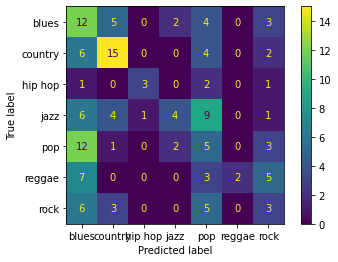

In [48]:
cm = confusion_matrix(gold_labels, predicted_labels, labels=['blues', 'country', 'hip hop', 'jazz', 'pop', 'reggae', 'rock'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['blues', 'country', 'hip hop', 'jazz', 'pop', 'reggae', 'rock'])
disp.plot()
plt.show()

In [2]:
train_genres = ['blues', 'country', 'hip hop', 'jazz', 'pop', 'reggae', 'rock']
test_genres = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Reggae", "Rock"]
genre_convert = {test_genre:train_genres[i] for i, test_genre in enumerate(test_genres)}

def convert_genre(input_genres):
    output_genres = []
    for genre in input_genres:
        if genre in genre_convert.keys():
            output_genres.append(genre_convert[genre])
    
    return output_genres

In [3]:
test_data = pd.read_csv("processed_data_final.csv").drop("Unnamed: 0", axis=1)
test_data.Lyrics = test_data.Lyrics.apply(literal_eval)
test_data.Genres = test_data.Genres.apply(literal_eval)
for i, (lyrics, genres) in test_data.iterrows():
    test_data.loc[i].Genres = convert_genre(genres)

test_data

,Lyrics,Genres
0,"[feel, unsure, take, hand, lead, dance, floor,...",[pop]
1,"[let, fool, ya, even, try, school, ya, oh, we'...",[pop]
2,"[baby, let's, cruise, away, confused, way, cle...",[pop]
3,"[know, sounds, funny, can't, stand, pain, girl...",[pop]
4,"[got, look, one, hoped, lad, face, beaming, sm...",[pop]
...,...,...
6994,"[waking, i'm, waking, life, facing, us, we've,...",[reggae]
6995,"[heard, say, see, got, seen, pray, pockets, th...",[reggae]
6996,"[time, need, war, time, fight, time, need, lov...",[reggae]
6997,"[time, need, war, time, fight, time, need, lov...",[reggae]


In [180]:
for i, (lyrics, genres) in test_data.iterrows():
    print(genres)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['words', 'music', 'thomas', 'wayne', 'girl', 'next', 'door', 'went', "a'walking", 'found', 'boy', 'likes', 'wanted', 'get', 'married', 'settle', 'life', 'girl', 'next', 'door', 'went', "a'walking", 'knew', 'right', 'came', 'home', 'half', 'past', 'ten', 'late', 'every', 'night', 'girl', 'next', 'door', 'went', "a'walking", 'found', 'boy', 'likes', 'wanted', 'get', 'married', 'settle', 'life', 'know', 'love', 'grand', 'never', 'took', 'love', 'second', 'hand', 'surprise', 'thought', 'love', 'paradise', 'girl', 'next', 'door', 'went', "a'walking", 'found', 'boy', 'likes', 'wanted', 'get', 'married', 'settle', 'life', 'girl', 'next', 'door', 'went', "a'walking", 'knew', 'right', 'came', 'home', 'half', 'past', 'ten', 'late', 'every', 'night', 'girl', 'next', 'door', 'went', "a'walking", 'found', 'boy', 'likes', 'wanted', 'get', 'married', 'settle', 'life', 'know', 'love', 'grand', 'never', 'took', 'love', 'second', 'hand', 'surprise', 'thought', 'love', 'paradise', 'girl', 'next', 'door

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [177]:
start = time.perf_counter()
predicted_labels = []
gold_labels = []

correct_preds = 0
incorrect_preds = 0

for i, (lyrics, genres) in test_data.iterrows():
#     if i % 1000 == 0:
#         break
    sentence = ' '.join(lyrics)

    pred = classifier.classify(sentence)
    if pred in genres:
        correct_preds += 1
    else:
        incorrect_preds += 1

    if i == 100:
        print(f"{i}: {time.perf_counter() - start}")
        print(correct_preds / (correct_preds + incorrect_preds))
        

100: 226.14836037500027
0.16831683168316833


KeyboardInterrupt: 

In [172]:
print(correct_preds)
print(incorrect_preds)
print(correct_preds / (correct_preds + incorrect_preds))

17
84
0.16831683168316833
